#Analyzing HTAN scRNASeq Data Using CellTypist

```
Title:  Analyzing HTAN scRNASeq Data Using Cell Typist
Author:  Dar'ya Pozhidayeva (dpozhida@systemsbiology.org)
Created: May 9th, 2024
```

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/isb-cgc/Community-Notebooks/blob/master/HTAN/Python%20Notebooks/Analyzing_HTAN_scRNASeq_Data_Using_CellTypist.ipynb)

# 1. Introduction & Overview
[HTAN](https://humantumoratlas.org/) is a National Cancer Institute (NCI)-funded Cancer Moonshot initiative to construct 3-dimensional atlases of the dynamic cellular, morphological, and molecular features of human cancers as they evolve from precancerous lesions to advanced disease ( [Cell April 2020](https://www.sciencedirect.com/science/article/pii/S0092867420303469) )


### 1.1 Goal

The goal of this notebook is to show users how public HTAN single cell level 4 data can be annotated with the [CellTypist](https://github.com/Teichlab/celltypist) library available in Python. The total time for this notebook should be about 20 minutes.


### 1.2 Inputs, Outputs, & Data

The data used in this analysis comes from HTAN single cell RNA sequencing data (Level 4, gene summarized). The dataset is pulled from Google BigQuery, which
was derived in April 2023 from an H5AD file (Synapse ID: syn51297089) submitted by the MSK HTAN Center. This data set contains both raw gene expression counts and log2(X+1) transformed, median-normalized expression from 62 pooled samples (N=147,137 cells). Data was generated using the 10X Genomics and was processed using SEQC, where reads were mapped to HG38, followed by cell filtering for mitochondrial fraction > 20%, empty droplet filtering (scCB2), and doublet removal (doubletdetection). Genes that were expressed in more than 10 cells were retained. Batch correction with fastMNN was performed for subsequent analysis, including UMAP visualization with scanpy and Phenograph clustering.



Generally, small cell lung cancer (SCLC) is an aggressive malignancy that includes subtypes defined by differential expression of ASCL1, NEUROD1, and POU2F3 (SCLC-A, -N, and -P, respectively). The motivation for generation of this data was described by the authors as defining the heterogeneity of tumors and their associated microenvironments across subtypes. To this end, they sequenced 155,098 transcriptomes from 21 human biospecimens, including 54,523 SCLC transcriptomes and constructed a single-cell atlas of SCLC patient tumors, with comparative lung adenocarcinoma (LUAD) and normal lung.

The published work associated with this dataset along with more information can be found here: https://linkinghub.elsevier.com/retrieve/pii/S1535610821004979

**NOTE:** When implementing CellTypist here, we use the [CellTypist immune cell model](https://www.celltypist.org/models) to classify the cells. Therefore, we use a subset of the data above that only contains immune cells provided by the authors.


# 2. Relevant Libraries for Analysis

To get started, we'll need to download and call a few python libraries!

In [1]:
# If using google colab include the following install; otherwise skip if you have scanpy installed:
!pip install scanpy
!pip install celltypist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 8.1 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=2d5098e07eef3f05696a742ccdfcfd8ee95afc4af7fe405ddc30a95f16a31fff
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 40.7 MB/s eta 0:00:00


In [2]:
# Data Analytics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import scanpy as sc
import scipy
from scipy.sparse import csr_matrix
import celltypist
from celltypist import models

# 3. Google Authentication

Running the BigQuery cells in this notebook requires a Google Cloud Project, instructions for creating a project can be found in the [Google Documentation](https://cloud.google.com/resource-manager/docs/creating-managing-projects#console). The instance needs to be authorized to bill the project for queries. For more information on getting started in the cloud see [Quick Start Guide to ISB-CGC](https://nbviewer.org/github/isb-cgc/Community-Notebooks/blob/master/Notebooks/Quick_Start_Guide_to_ISB_CGC.ipynb) and alternative authentication methods can be found in the [Google Documentation](https://cloud.google.com/resource-manager/docs/creating-managing-projects#console).

## 3.1 Authenticating with Google Credentials

#### Option 1. Running in Google Colab

Before getting started, keep in mind that there are some differences in running this notebook depending on if you are using Google Colab or running locally. We've included notes such as the following to skip or run specific lines of code depending on your setup.

If you are using Google Colab, run the code block below to authenticate:

In [3]:
from google.colab import auth
auth.authenticate_user()

#### Option 2. Running on local machine

Alternatively, if you're running the notebook locally, take the following steps to authenticate.

1.   Run `gcloud auth application-default login` on your local machine
2.   Run the command below replacing `<path to key>` with the path to your credentials file

In [4]:
#%env GOOGLE_APPLICATION_CREDENTIALS=<path to key>

## 3.2 Initializing the Google BigQuery client

In [5]:
# Import the Google BigQuery client
from google.cloud import bigquery

# Set the google project that will be billed for this notebook's computations
google_project = 'my-project'

# Create a client to access the data within BigQuery
client = bigquery.Client(google_project)

#4. Pull Data from Google BigQuery

Once authentication and project setup is complete, we can work with HTAN data available in BigQuery.

To do this, we create several SQL queries to access different parts of the level 4 single cell RNA sequencing data. This is done in preparation for constructing an AnnData object. For more information on AnnData Objects in HTAN, [check out our notebook here.](https://github.com/ncihtan/Community-Notebooks/blob/master/HTAN/Python%20Notebooks/Building_AnnData_with_Subset_of_Cells_from_BQ.ipynb)

In [6]:
# We'll use the following query to fetch the main count matrix
X = client.query("""
SELECT iObs, X_value, iVar FROM `isb-cgc-bq.HTAN.scRNAseq_MSK_SCLC_immune_cells_current`
    """).result().to_dataframe()

In [7]:
X

,iObs,X_value,iVar
0,14531,2.076389,10044
1,8497,1.850209,10051
2,11362,1.555934,10378
3,1638,3.253945,10937
4,198,4.009503,11337
...,...,...,...
21202373,8236,5.177607,7561
21202374,707,3.377078,8307
21202375,9242,1.174704,8986
21202376,5576,1.140281,11167


In [8]:
# We'll use the following query to fetch the gene symbols for the array
var = client.query("""
SELECT DISTINCT iVar, feature_name as GeneSymbol FROM `isb-cgc-bq.HTAN.scRNAseq_MSK_SCLC_immune_cells_current`
    """).result().to_dataframe()

In [9]:
var

,iVar,GeneSymbol
0,3055,CCNL1
1,3158,CD63
2,3554,CHCHD2
3,5253,DDX5
4,5837,EEF1D
...,...,...
18569,8541,HSPB11
18570,8632,IDS
18571,8648,IFI44L
18572,7294,GATAD2A


In [10]:
#Lastly, we use the following query to fetch the index for cells and cell metadata
obs = client.query("""
SELECT DISTINCT iObs, total_counts, n_genes_by_counts, log1p_n_genes_by_counts, log1p_total_counts, mito_frac, RBP_frac, author_cell_type, cell_type_broad, cell_type, tissue, sex, treatment FROM `isb-cgc-bq.HTAN.scRNAseq_MSK_SCLC_immune_cells_current`
    """).result().to_dataframe()

In [11]:
obs

,iObs,total_counts,n_genes_by_counts,log1p_n_genes_by_counts,log1p_total_counts,mito_frac,RBP_frac,author_cell_type,cell_type_broad,cell_type,tissue,sex,treatment
0,2139,6919.0,1969,7.585789,8.842171,0.022980,0.170978,Plasma cell,B cell,plasma cell,lung,female,Naive
1,13215,6777.0,1525,7.330405,8.821438,0.003541,0.164232,Plasma cell,B cell,plasma cell,lung,female,Naive
2,13939,7152.0,2062,7.631917,8.875287,0.090185,0.227768,Mast,Myeloid,mast cell,lymph node,female,"Platinum Doublet,Immunotherapy"
3,6130,4329.0,1111,7.013915,8.373322,0.031185,0.382767,Mast,Myeloid,mast cell,lung,female,Platinum Doublet
4,14895,4946.0,1323,7.188413,8.506536,0.035382,0.302264,Mast,Myeloid,mast cell,lung,male,Naive
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16470,13398,6631.0,2256,7.721792,8.799662,0.046901,0.152466,CD8+ Teff,T cells,"effector CD8-positive, alpha-beta T cell",lung,female,Platinum Doublet
16471,8386,4801.0,1666,7.418781,8.476788,0.092481,0.286815,CD8+ Teff,T cells,"effector CD8-positive, alpha-beta T cell",liver,male,"Platinum Doublet,Immunotherapy,TMZ,Other chemo..."
16472,5390,4273.0,1567,7.357556,8.360306,0.063890,0.240346,CD8+ Teff,T cells,"effector CD8-positive, alpha-beta T cell",liver,male,"Platinum Doublet,Immunotherapy,TMZ,Other chemo..."
16473,14561,4559.0,1503,7.315884,8.425077,0.091687,0.273306,CD8+ Teff,T cells,"effector CD8-positive, alpha-beta T cell",liver,male,"Platinum Doublet,Immunotherapy,TMZ,Other chemo..."


In order to create the AnnData Object, the data fetched from BiqQuery must be re-structured. To do this, we run the following re-indexing lines.

In [12]:
# fix the obs index by reindexing
# this maps the X table to the obs table
iObsDict = dict(zip(obs.iObs, obs.index))
X.iObs = [iObsDict[a] for a in X.iObs]

In [13]:
# the var index also needed a fix by reindexing
# this maps the X table to the var table
iVarDict = dict(zip(var.iVar, var.index))
X.iVar = [iVarDict[a] for a in X.iVar]
# and scanpy indexes things by gene symbol
var.index = var.GeneSymbol

In [14]:
# now with indices that map to the obs and var tables.
X

,iObs,X_value,iVar
0,13910,2.076389,8511
1,13831,1.850209,17688
2,12789,1.555934,8512
3,14877,3.253945,13030
4,12548,4.009503,13034
...,...,...,...
21202373,3557,5.177607,17812
21202374,3824,3.377078,3928
21202375,3567,1.174704,13170
21202376,3717,1.140281,17825


Now, we rebuild the main count table as a sparse matrix before building the AnnData object.

In [15]:
# convert the pandas table to a sparse matrix
sparse_mat = scipy.sparse.csr_matrix( (X.X_value, (X.iObs, X.iVar)) )
sparse_mat = np.nan_to_num(sparse_mat)

In [16]:
# now we can build the AnnData
adata = sc.AnnData(X=sparse_mat, obs=obs, var=var)
adata.var_names_make_unique()

In [17]:
adata
# The adata is ready to go!

AnnData object with n_obs × n_vars = 16475 × 18574
    obs: 'iObs', 'total_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'mito_frac', 'RBP_frac', 'author_cell_type', 'cell_type_broad', 'cell_type', 'tissue', 'sex', 'treatment'
    var: 'iVar', 'GeneSymbol'

# FILTERING AND QC

Now that we have the data, we want to check out and potentially filter the data in order to set the stage for CellTypist use.
Since the data generators have already included a number of QC flags in the obs layer, we'll plot those first and infer whether the data has been filtered.

count    16475.000000
mean         0.065123
std          0.039501
min          0.000000
25%          0.031790
50%          0.061619
75%          0.087659
max          0.200000
Name: mito_frac, dtype: float64

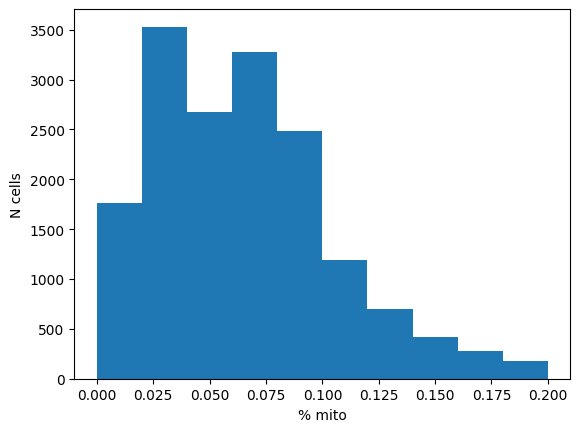

In [18]:
plt.hist(adata.obs['mito_frac'])
plt.xlabel('% mito')
plt.ylabel('N cells')
pd.DataFrame.describe(adata.obs['mito_frac'])

We can see from this data that the authors already filtered cells with mito_frac > 20% (as mentioned in the manuscript).



count    16475.000000
mean      4787.326859
std       4556.432560
min        101.000000
25%       2389.500000
50%       3901.000000
75%       5727.500000
max      74341.000000
Name: total_counts, dtype: float64

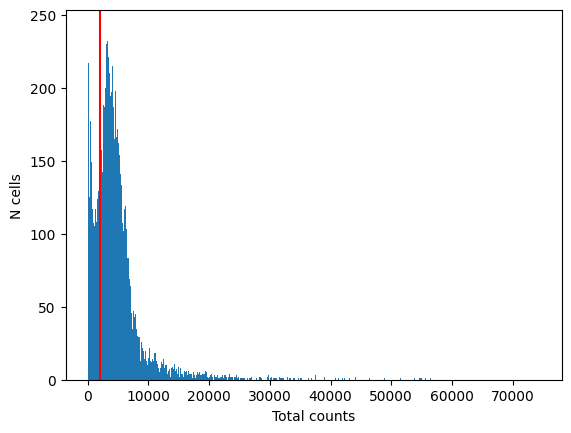

In [19]:
#plot histogram of number of counts per cell
plt.hist(adata.obs['total_counts'], bins=1000)
plt.xlabel('Total counts')
plt.ylabel('N cells')
plt.axvline(2000, color='red')
#plt.xlim(0,1e3) just to take a look if there was filtering around 0 counts per cell
pd.DataFrame.describe(adata.obs['total_counts'])


From the plot and the statistics, we can infer that the step 1 in filtering (true cells are distinguished from empty droplets based on the cumulative distribution of total molecule count) used a threshold of 100 for total counts.

count        16475.0
mean     1412.697785
std         842.6296
min             71.0
25%            892.5
50%           1301.0
75%           1760.0
max           7431.0
Name: n_genes_by_counts, dtype: Float64

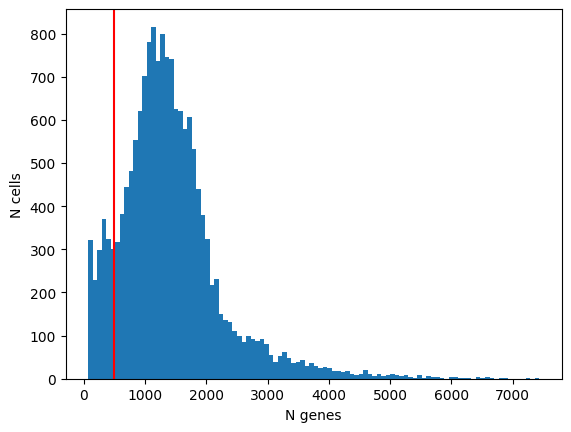

In [20]:
#plot histogram of number of unique genes by cells
plt.hist(adata.obs['n_genes_by_counts'], bins=100)
plt.xlabel('N genes')
plt.ylabel('N cells')
plt.axvline(500, color='red')
#plt.xlim(0,4e3)
pd.DataFrame.describe(adata.obs['n_genes_by_counts'])

From the plot and the statistics, we can infer that the step 3 in filtering (3) cells with low library complexity are filtered (cells that express very few unique genes)) used a threshold of 70 for number of genes expressed by a cell.

So, it appears that we already have a file with data that went through pre-processing. No further filtering will be made to the original file.

# Data Normalization and Log-transformation

Now that filtering has been assessed, the next step before using the CellTypist library is normalization. In order to call cells, the expression matrix must be pre-processed (and is required) as log1p normalised expression to 10,000 counts per cell.

So, we call the following functions:

In [21]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

We also run PCA and UMAP from the scanpy library for visualization:

In [22]:
sc.tl.pca(adata, svd_solver='arpack')

In [23]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [24]:
sc.tl.umap(adata)

In order to check the previous steps we've implemented, let's plot the UMAP we've generated. In this case, the authors have already provided cell type labels. We can see them plotted below. This will be used as a means of comparison to cell typist predictions.

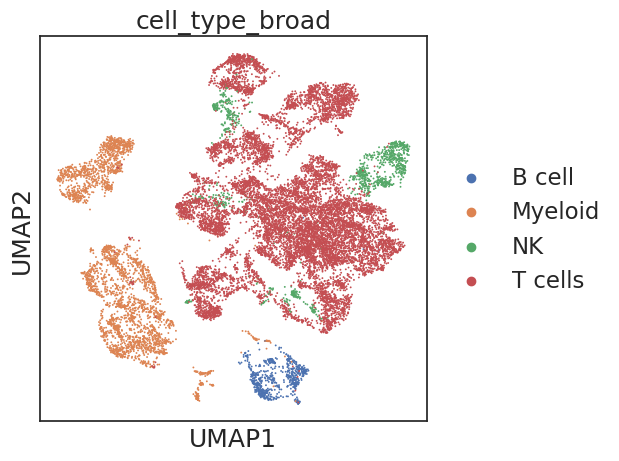

In [25]:
sns.set(rc={'figure.figsize':(5,5)}, style='white', font_scale=1.5)
sc.pl.umap(adata, color="cell_type_broad")

We can see distinct clusters of cell types! Therefore, we're ready to move on to the final step.

# Implementation of CellTypist

CellTypist is an open source tool for automated cell type annotations as well as a working group in charge of curating models and ontologies. More information can be found at https://www.celltypist.org/. They also have a detailed tutorial which can be helpful if it's your first time using this library: https://colab.research.google.com/github/Teichlab/celltypist/blob/main/docs/notebook/celltypist_tutorial_ml.ipynb#scrollTo=passive-arrest

As discussed previously, the cells in this dataset are a subset of only immune small cell lung cancer. Therefore, the model used here is the low resolution immune cell model.

This model is was built from immune sub-populations combined from 20 tissues of 18 studies. More details can be found: https://www.celltypist.org/models

In [26]:
#The model name refers to the grouping - thus, high means low resolution (less cell categories)
model = models.Model.load(model = 'Immune_All_High.pkl')

In [27]:
# Additionally, model information can be found by just checking the model variable:
model

CellTypist model with 32 cell types and 6639 features
    date: 2022-07-16 08:53:00.959521
    details: immune populations combined from 20 tissues of 18 studies
    source: https://doi.org/10.1126/science.abl5197
    version: v2
    cell types: B cells, B-cell lineage, ..., pDC precursor
    features: A1BG, A2M, ..., ZYX

In [28]:
# This is also true for model cell types:
model.cell_types

array(['B cells', 'B-cell lineage', 'Cycling cells', 'DC', 'DC precursor',
       'Double-negative thymocytes', 'Double-positive thymocytes', 'ETP',
       'Early MK', 'Endothelial cells', 'Epithelial cells',
       'Erythrocytes', 'Erythroid', 'Fibroblasts', 'Granulocytes',
       'HSC/MPP', 'ILC', 'ILC precursor', 'MNP', 'Macrophages',
       'Mast cells', 'Megakaryocyte precursor',
       'Megakaryocytes/platelets', 'Mono-mac', 'Monocyte precursor',
       'Monocytes', 'Myelocytes', 'Plasma cells', 'Promyelocytes',
       'T cells', 'pDC', 'pDC precursor'], dtype=object)

Using the model to predict the cell types is accomplished with the following line. Here, there are several arguments for cell calling thresholds which are described in detail within the CellTypist documentation.

In [29]:
predictions=celltypist.annotate(adata, model = model, mode = 'best match', p_thres = 0.5, majority_voting = True)

In [30]:
# Add the predictions to our main dataset
adata = predictions.to_adata()

In [31]:
predictions.predicted_labels

,predicted_labels,over_clustering,majority_voting
0,Plasma cells,137,B cells
1,Plasma cells,132,Mast cells
2,Mast cells,132,Mast cells
3,Mast cells,132,Mast cells
4,Mast cells,132,Mast cells
...,...,...,...
16470,T cells,116,T cells
16471,T cells,116,T cells
16472,T cells,21,T cells
16473,T cells,38,T cells


Now we can see that we've successfully used CellTypist to annotate the data.

# Create Plots with Predictions and Existing Labels

Lastly, we want to compare the author cell labels to those produced by CellTypist. Additionally, we are interested in the cell label score. In order to compare these outputs, we plot UMAPs of the original author-generated, broad cell types side-by-side to those generated by CellTypist.

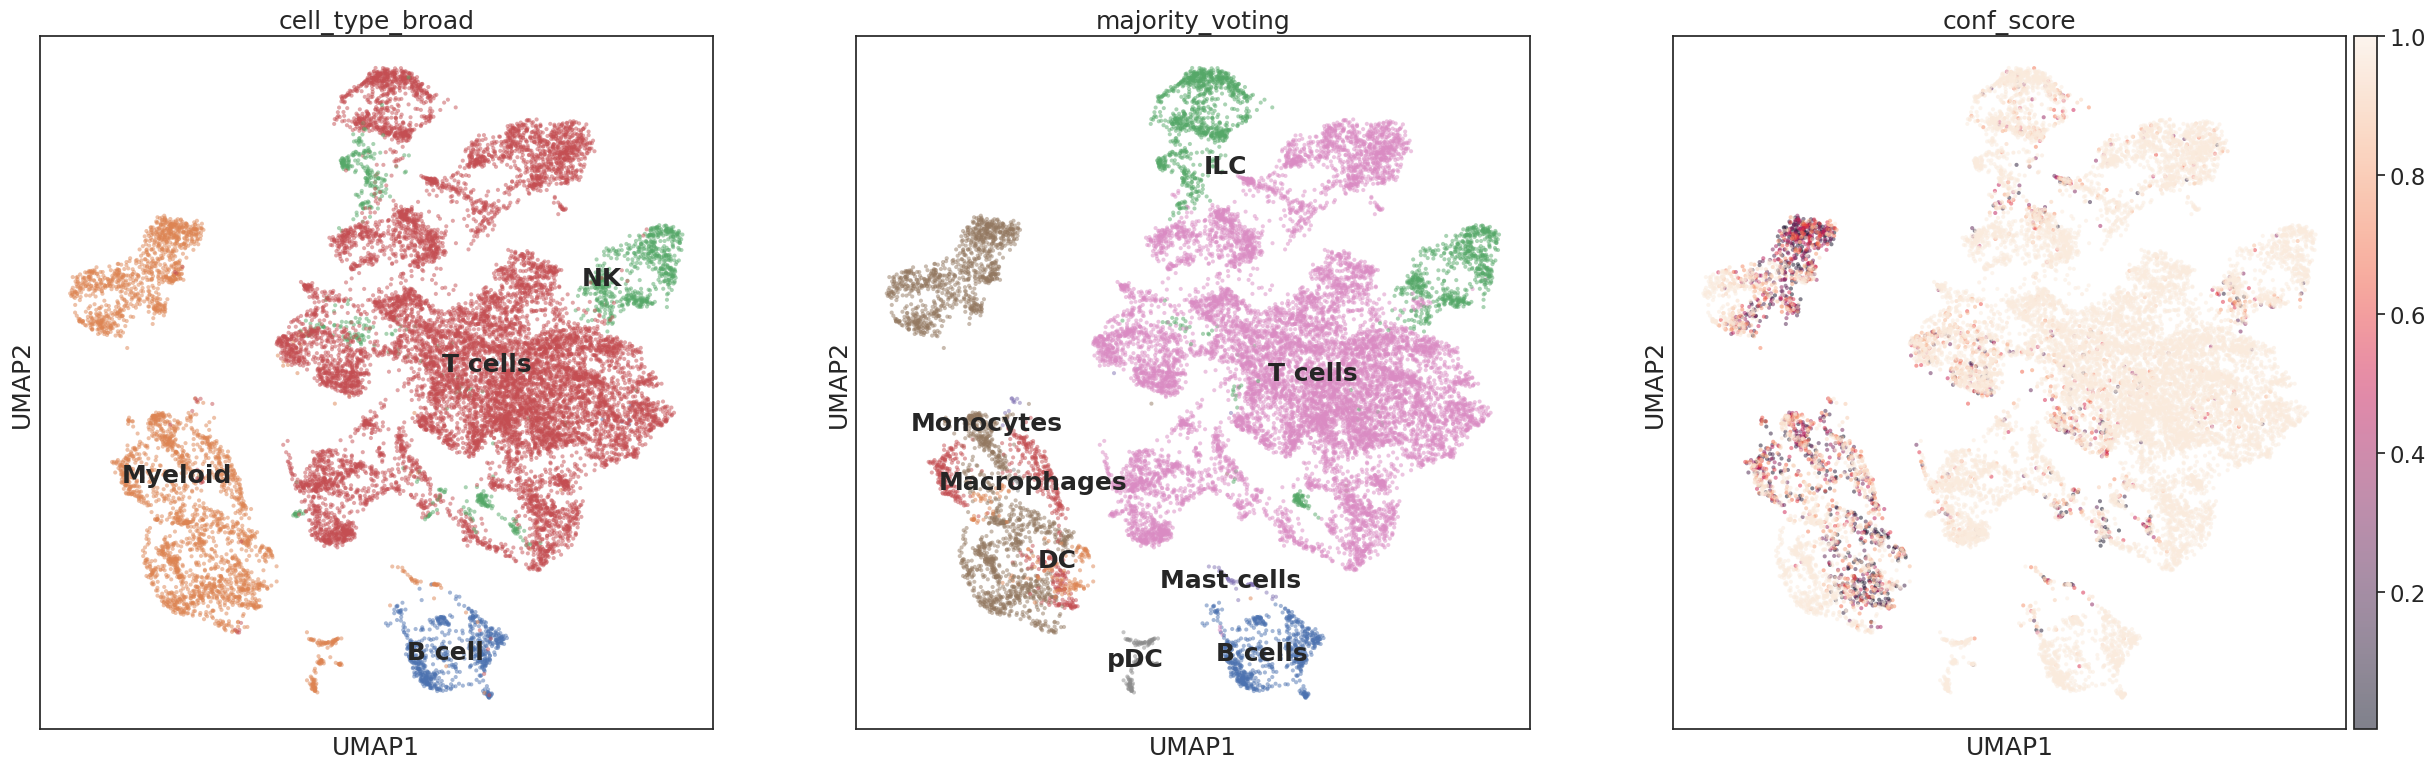

In [32]:
plt.rcParams['figure.figsize'] = (9, 9)
sc.pl.umap(adata, color = ["cell_type_broad",'majority_voting', 'conf_score'], legend_loc = 'on data', alpha = 0.5, size = 35)


In the figure above, we see the author cell types on the left-most side, the predicted cell types in the middle, and the confidence scores for the predictions in the right-most plot.


One interesting outcome that is immediately noticible is that, even with default parameters, the CellTypist labels closely align with those outlined by the authors. Additionally, those closely aligned are shown to have a relatively high confidence score (right-most plot).

For example, predicted T-cells and author T-cell annotations are tightly distributed within the same UMAP clusters.

Another interesting outcome of this analysis is that, CellTypist chose a different labeling category for some cells that do not match the author's annotation. For example, where the author's mapped Natural Killer (NK) cells, CellTypist defined the cells as Innate Lymphoid Celsl (ILCs). Biologically, this makes sense because ILC cells are a supercategory of NK cells [1,2], and this is likely a result of the model selection in CellTypist. Given that the model used was for a low resolution of immune cells it makes sense that the NK cells were folded into the ILC label.

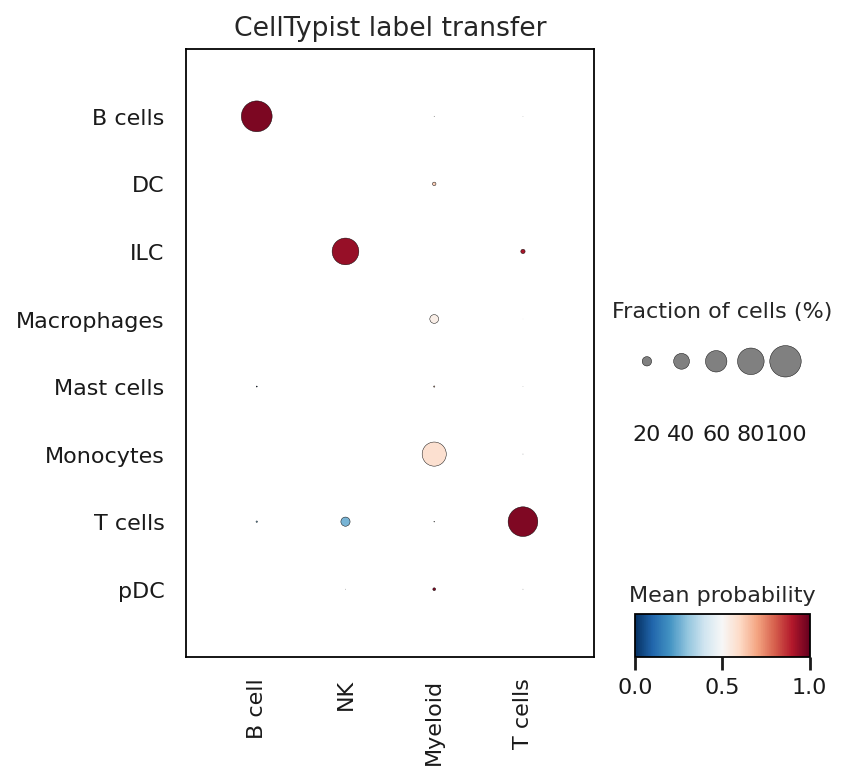

In [63]:
sc.set_figure_params(scanpy=True, fontsize=12)
celltypist.dotplot(predictions, use_as_reference = 'cell_type_broad', use_as_prediction = 'majority_voting', figsize = [5, 5])

To further understand the performance of CellTypist relative to the author annotations, we can plot a label transfer dotplot. We can see above that, again, the predicted labels are fairly consistent with those reported by the authors. Thus, we can conclude with confidence that CellTypist is fairly efficient at labeling cell types for data sets consistent with the cell type the model was trained on (i.e immune cells in this case).

It is worth trying other models in the CellTypist suite to see how consistent this result is and whether these results hold true for models that are used on data they were not originally trained on phenotyping. For example, would the immune model be able to distinguish immune cells from non-immune cells in single cell data that is a homogenous mix of cell types (not just immune).

# 6. Relevant Citations and Links

[HTAN Portal](https://humantumoratlas.org/)   

[HTAN Overview paper, Cell, April 2020](https://www.sciencedirect.com/science/article/pii/S0092867420303469)

[Data Used from MSK](https://www.sciencedirect.com/science/article/pii/S1535610821004979?via%3Dihub)

# Sources Cited

1. https://en.wikipedia.org/wiki/Innate_lymphoid_cell

2. https://www.frontiersin.org/journals/immunology/articles/10.3389/fimmu.2019.00861/full